<a href="https://colab.research.google.com/github/abdalrahmenyousifMohamed/ML/blob/main/chapter04/imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install imbalanced-learn==0.10.1
import warnings
warnings.filterwarnings('ignore')

# Plotting helper function

In [2]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import recall_score, precision_score

def plot_dataset(X, y):
  cmap_bold = ["darkorange", "darkblue"]
  markers = {1: "X", 0: "v"}
  sns.scatterplot(
      x=X[:, 0],
      y=X[:, 1],
      hue=y,
      palette=cmap_bold,
      alpha=1.0,
      edgecolor="black",
      style=y, markers=markers
  )

def plot_decision_boundary(X, y, clf, clf_name):
  _, ax = plt.subplots()
  cmap_light = ListedColormap(["orange", "white"])
  disp = DecisionBoundaryDisplay.from_estimator(
      clf,
      X,
      cmap=cmap_light,
      ax=ax,
      response_method="predict",
      alpha=0.5,
      xlabel='feature_1',
      ylabel='feature_2',
  )
  disp.plot(plot_method="contour", cmap="gist_gray", ax = ax, alpha = 1.)
  # Plot also the training points
  plot_dataset(X, y)
  plt.title("2-Class classification using %s classifier" %clf_name)


# from: https://imbalanced-learn.org/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py
def plot_decision_function(X, y, clf, ax):
  """Plot the decision function of the classifier and the original data"""
  plot_step = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
  )

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, alpha=0.4)
  ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
  ax.set_title(f"Resampling using {clf[0].__class__.__name__}")

In [3]:
from sklearn.metrics import fbeta_score
from scipy.spatial import distance_matrix

def compute_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f2 = fbeta_score(y_test, y_pred, beta=2.)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return f2, precision, recall

def remove_overlapping(X):
    c1_indexes =  np.where(y == 0)[0]
    c2_indexes =  np.where(y == 1)[0]
    centroid = np.mean(X[c1_indexes],axis=0,keepdims= True)
    c2_points =  X[c2_indexes]
    distances = distance_matrix(c2_points , centroid)
    nearest_points_to_c1 = c2_indexes[np.where(distances < 3)[0]]

    move =  np.repeat(np.array([[0,-6]]),nearest_points_to_c1.shape[0], axis=0)
    X[nearest_points_to_c1] = X[nearest_points_to_c1] + move
    return X

# Create dataset

y_train:  Counter({0: 62370, 1: 630})
y_test:  Counter({0: 26730, 1: 270})


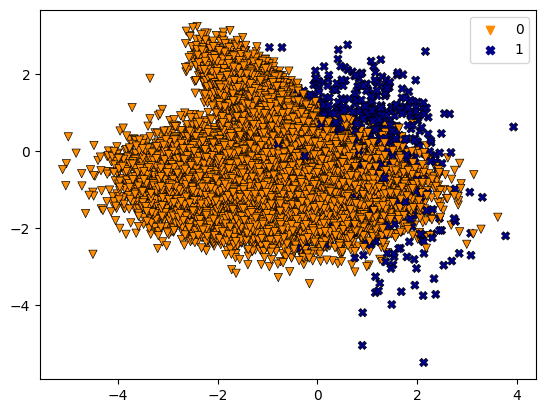

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter

X, y = make_classification(n_samples=90000, n_features=2,
                          n_redundant=0, n_classes=2, flip_y=0,
                          n_clusters_per_class=2, class_sep=0.89,
                          weights=[0.99], random_state=81)

# X = remove_overlapping(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)

print('y_train: ', Counter(y_train))
print('y_test: ', Counter(y_test))

plot_dataset(X_train, y_train)

# Decision Tree (baseline)

y_train:  Counter({0: 62370, 1: 630})
y_test:  Counter({0: 26730, 1: 270})


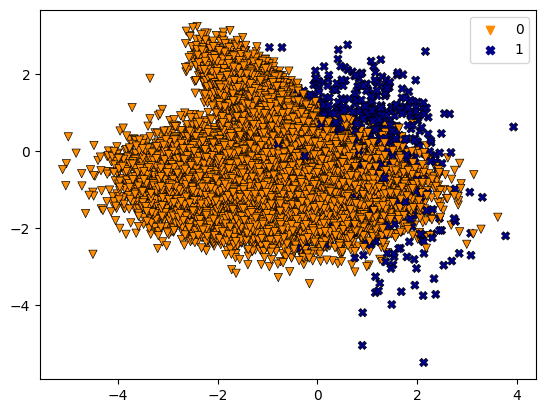

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter

X, y = make_classification(n_samples=90000, n_features=2,
                          n_redundant=0, n_classes=2, flip_y=0,
                          n_clusters_per_class=2, class_sep=0.89,
                          weights=[0.99], random_state=81)

# X = remove_overlapping(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)

print('y_train: ', Counter(y_train))
print('y_test: ', Counter(y_test))

plot_dataset(X_train, y_train)

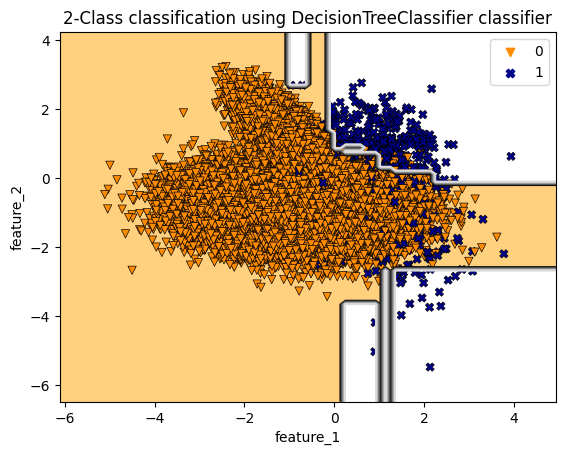

Average Precision Score for DecisionTreeClassifier: 0.47927888603371815
AUC-ROC Score for DecisionTreeClassifier: 0.929585151930831
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.39      1.00      0.62      0.41     26730
          1       0.83      0.39      1.00      0.53      0.62      0.36       270

avg / total       0.99      0.99      0.39      0.99      0.62      0.41     27000

f2-score: 0.431 precision_rf: 0.825 recall: 0.385


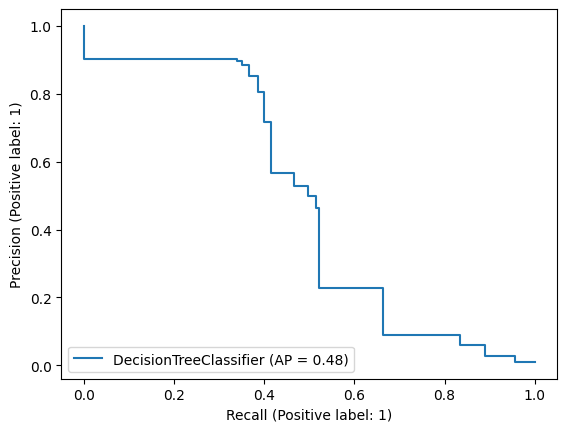

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from imblearn.metrics import classification_report_imbalanced

tree_clf = DecisionTreeClassifier(random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, tree_clf, 'DecisionTreeClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(tree_clf, X_test, y_test, ax = plt.gca(), name = "DecisionTreeClassifier")

y_pred_proba = tree_clf.predict_proba(X_test)[:, 1]
avg_precision_tree = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for DecisionTreeClassifier: {avg_precision_tree}")

roc_auc_tree = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for DecisionTreeClassifier: {roc_auc_tree}")

y_pred = tree_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_tree, precision_val_tree, recall_val_tree =  compute_scores(tree_clf, X_test, y_test)
print(f"f2-score: {f2_tree:.3f}", f"precision_rf: {precision_val_tree:.3f}", f"recall: {recall_val_tree:.3f}")

# Random Forest

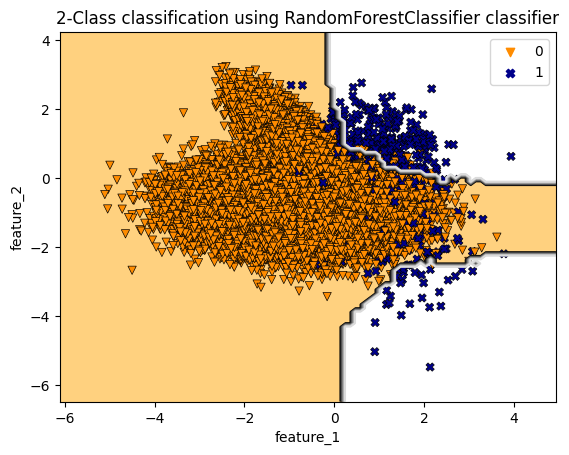

Average Precision Score for RandomForest: 0.5619874585804394
AUC-ROC Score for RandomForestClassifier: 0.9568804644524808
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.36      1.00      0.60      0.38     26730
          1       0.92      0.36      1.00      0.52      0.60      0.34       270

avg / total       0.99      0.99      0.37      0.99      0.60      0.38     27000

f2-score: 0.409 precision_rf: 0.915 recall: 0.359


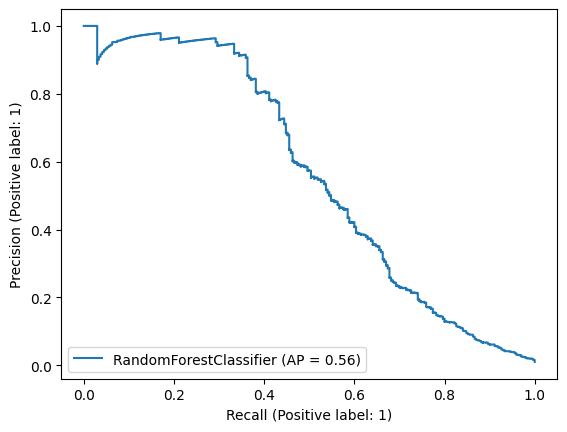

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from imblearn.metrics import classification_report_imbalanced

RF_clf = RandomForestClassifier(random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, RF_clf, 'RandomForestClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(), name = "RandomForestClassifier")

y_pred_proba = RF_clf.predict_proba(X_test)[:, 1]
avg_precision_rf = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for RandomForest: {avg_precision_rf}")

roc_auc_rf = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for RandomForestClassifier: {roc_auc_rf}")

y_pred = RF_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_rf, precision_val_rf, recall_val_rf =  compute_scores(RF_clf, X_test, y_test)
print(f"f2-score: {f2_rf:.3f}", f"precision_rf: {precision_val_rf:.3f}", f"recall: {recall_val_rf:.3f}")

# Balanced Random Forest with undersampling

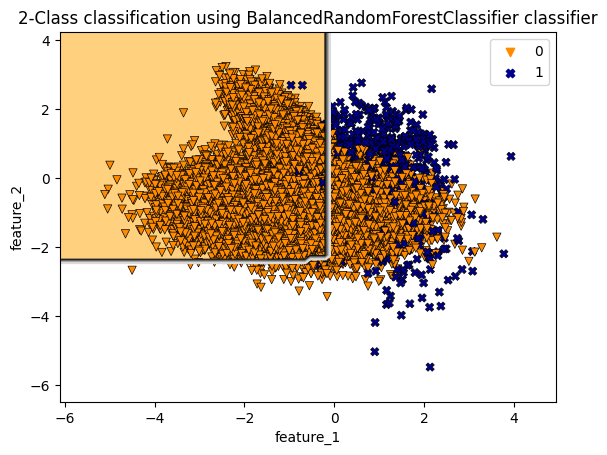

Average Precision Score for BalancedRandomForest: 0.48968586554029214
AUC-ROC Score for BalancedRFClassifier: 0.9498922697482368
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      0.90      0.92      0.88      0.77     26730
          1       0.06      0.90      0.86      0.11      0.88      0.78       270

avg / total       0.99      0.86      0.90      0.91      0.88      0.77     27000

f2-score: 0.237 precision: 0.060 recall: 0.900


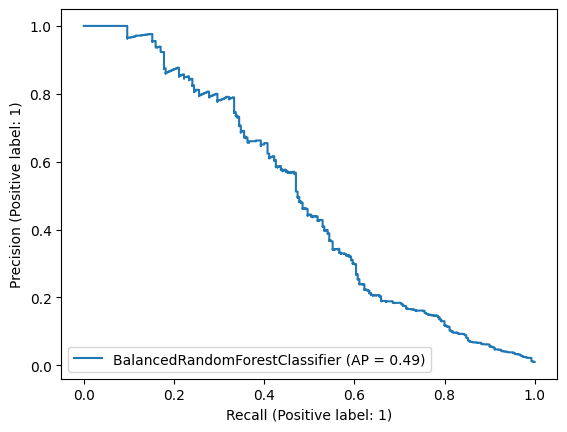

In [10]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay

max_f2 = 0
balanced_RF_clf = BalancedRandomForestClassifier(sampling_strategy="auto", random_state=0,
                                                max_depth=6, max_features=1, min_samples_split=0.2, min_samples_leaf=10).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, balanced_RF_clf, 'BalancedRandomForestClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(balanced_RF_clf, X_test, y_test, ax = plt.gca(), name = "BalancedRandomForestClassifier")

y_pred_proba = balanced_RF_clf.predict_proba(X_test)[:, 1]
avg_precision_brf = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for BalancedRandomForest: {avg_precision_brf}")

roc_auc_brf = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for BalancedRFClassifier: {roc_auc_brf}")

y_pred = balanced_RF_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_brf, precision_val_brf, recall_val_brf =  compute_scores(balanced_RF_clf, X_test, y_test)

print(f"f2-score: {f2_brf:.3f}", f"precision: {precision_val_brf:.3f}", f"recall: {recall_val_brf:.3f}")


# BaggingClassifier

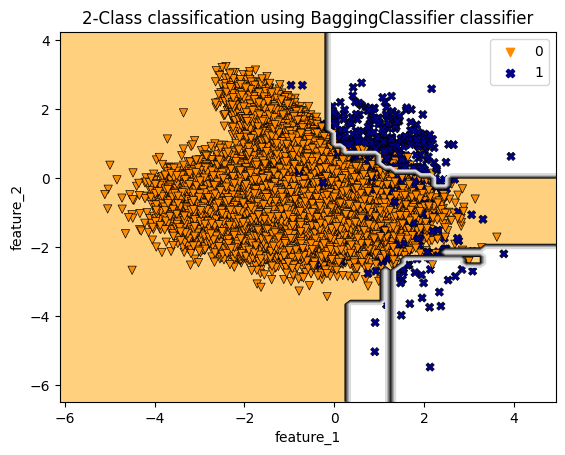

Average Precision Score for BaggingClassifier: 0.5616962875017796
AUC-ROC Score for BaggingClassifier: 0.9588186390655526
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.40      1.00      0.64      0.43     26730
          1       0.83      0.40      1.00      0.54      0.64      0.38       270

avg / total       0.99      0.99      0.41      0.99      0.64      0.43     27000

f2-score: 0.450 precision: 0.832 recall: 0.404


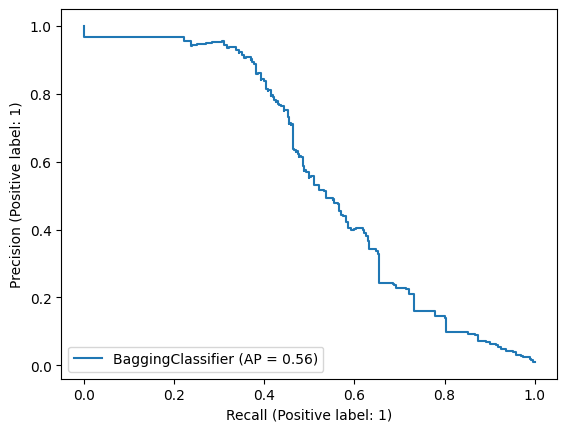

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier

clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6), random_state=0).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, clf, 'BaggingClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax = plt.gca(),name = "BaggingClassifier")

y_pred_proba = clf.predict_proba(X_test)[:, 1]
avg_precision_bagging = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for BaggingClassifier: {avg_precision_bagging}")

roc_auc_bagging = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for BaggingClassifier: {roc_auc_bagging}")

y_pred = clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_bagging, precision_val_bagging, recall_val_bagging =  compute_scores(clf, X_test, y_test)
print(f"f2-score: {f2_bagging:.3f}", f"precision: {precision_val_bagging:.3f}", f"recall: {recall_val_bagging:.3f}")


# Underbagging via BalancedBaggingClassifier



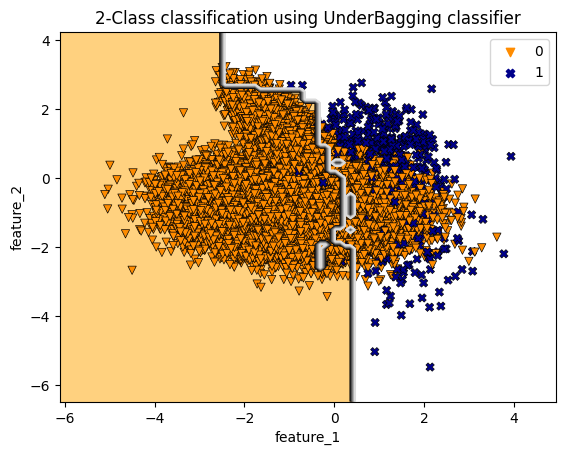

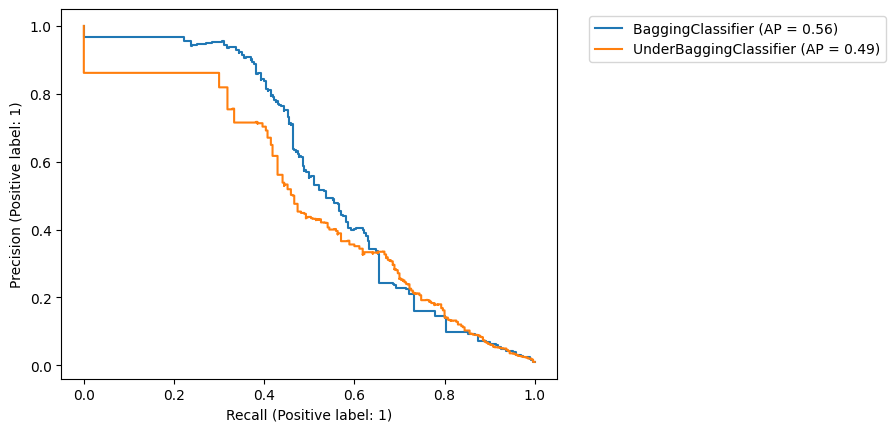

Average Precision Score for UnderBaggingClassifier: 0.4939007382820136
AUC-ROC Score for UnderBaggingClassifier: 0.9559553698854111
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.90      0.88      0.95      0.89      0.80     26730
          1       0.08      0.88      0.90      0.15      0.89      0.79       270

avg / total       0.99      0.90      0.88      0.94      0.89      0.80     27000

f2-score: 0.306 precision: 0.085 recall: 0.878


In [12]:
import imblearn
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
underbagging_clf = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                             random_state=0,
                                             sampler=imblearn.under_sampling.RandomUnderSampler(replacement=True)
                                             ).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, underbagging_clf, 'UnderBagging')
plt.show()

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax = plt.gca(),name = "BaggingClassifier")
PrecisionRecallDisplay.from_estimator(underbagging_clf, X_test, y_test, ax = plt.gca(),name = "UnderBaggingClassifier")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

y_pred_proba = underbagging_clf.predict_proba(X_test)[:, 1]
avg_precision_underbagging = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for UnderBaggingClassifier: {avg_precision_underbagging}")

roc_auc_underbagging = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for UnderBaggingClassifier: {roc_auc_underbagging}")

y_pred = underbagging_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_underbagging, precision_val_underbagging, recall_val_underbagging =  compute_scores(underbagging_clf, X_test, y_test)
print(f"f2-score: {f2_underbagging:.3f}", f"precision: {precision_val_underbagging:.3f}", f"recall: {recall_val_underbagging:.3f}")



# Overbagging via BalancedBaggingClassifier



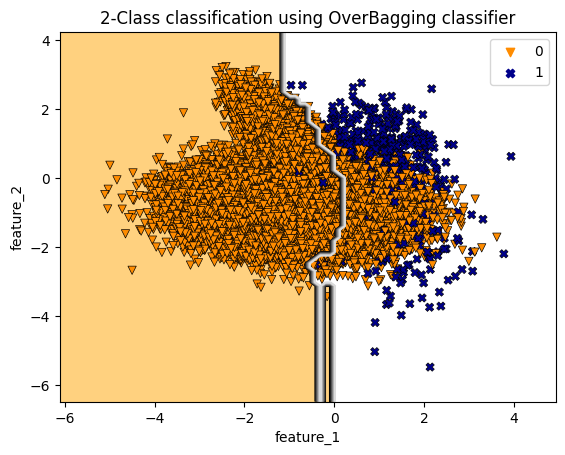

Average Precision Score for OverBaggingClassifier: 0.5701829905605159
AUC-ROC Score for OverBaggingClassifier: 0.957109850216846
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.90      0.87      0.95      0.89      0.79     26730
          1       0.08      0.87      0.90      0.15      0.89      0.79       270

avg / total       0.99      0.90      0.87      0.94      0.89      0.79     27000

f2-score: 0.305 precision: 0.085 recall: 0.874


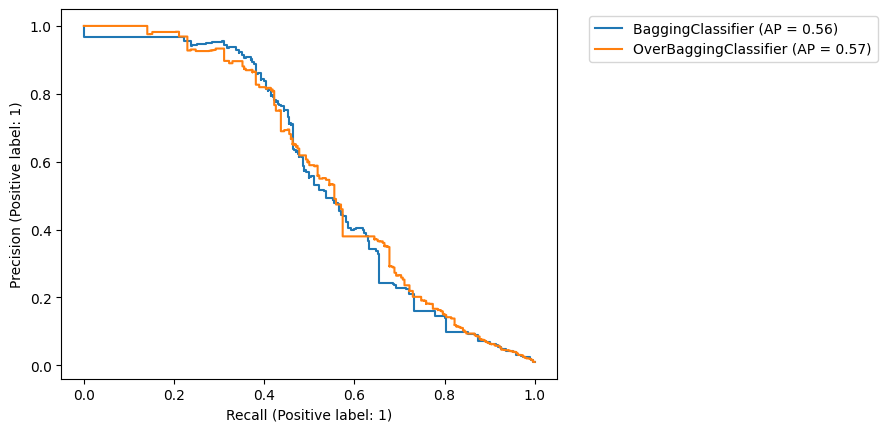

In [13]:
import imblearn
from imblearn.ensemble import BalancedBaggingClassifier

overbagging_clf = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                            random_state=0,
                                            sampler=imblearn.over_sampling.RandomOverSampler(shrinkage=1))\
                                            .fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, overbagging_clf, 'OverBagging')
plt.show()

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax = plt.gca(),name = "BaggingClassifier")
PrecisionRecallDisplay.from_estimator(overbagging_clf, X_test, y_test, ax = plt.gca(),name = "OverBaggingClassifier")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

y_pred_proba = overbagging_clf.predict_proba(X_test)[:, 1]
avg_precision_overbagging = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for OverBaggingClassifier: {avg_precision_overbagging}")

roc_auc_overbagging = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for OverBaggingClassifier: {roc_auc_overbagging}")

y_pred = overbagging_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_overbagging, precision_val_overbagging, recall_val_overbagging =  compute_scores(overbagging_clf, X_test, y_test)
print(f"f2-score: {f2_overbagging:.3f}", f"precision: {precision_val_overbagging:.3f}", f"recall: {recall_val_overbagging:.3f}")




# SMOTEBagging via BalancedBaggingClassifier

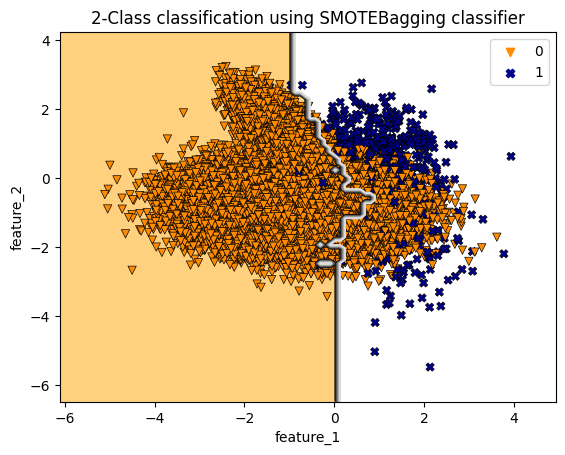

Average Precision Score for SMOTEBaggingClassifier: 0.558985400801953
AUC-ROC Score for SMOTEBaggingClassifier: 0.9553131451691124
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.93      0.84      0.96      0.88      0.79     26730
          1       0.11      0.84      0.93      0.19      0.88      0.77       270

avg / total       0.99      0.93      0.84      0.96      0.88      0.79     27000

f2-score: 0.357 precision: 0.108 recall: 0.837


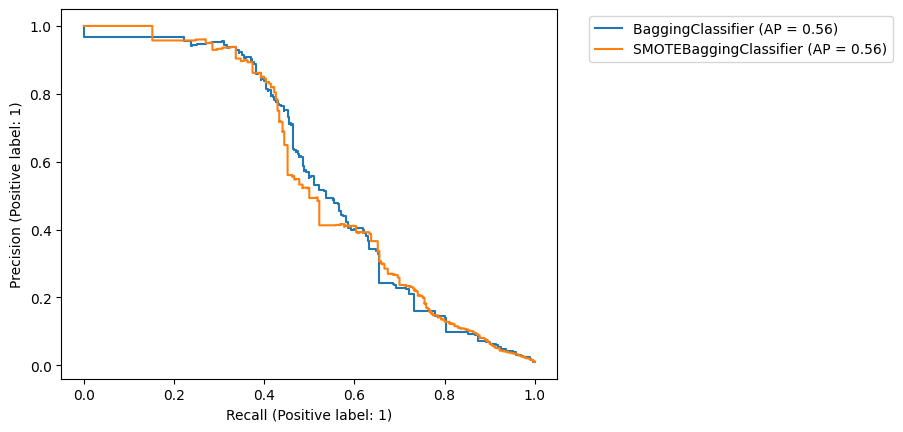

In [14]:
import imblearn
from imblearn.ensemble import BalancedBaggingClassifier

smotebagging_clf = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                             random_state=0,
                                             sampler=imblearn.over_sampling.SMOTE()).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, smotebagging_clf, 'SMOTEBagging')
plt.show()

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax = plt.gca(),name = "BaggingClassifier")
PrecisionRecallDisplay.from_estimator(smotebagging_clf, X_test, y_test, ax = plt.gca(),name = "SMOTEBaggingClassifier")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

y_pred_proba = smotebagging_clf.predict_proba(X_test)[:, 1]
avg_precision_smotebagging = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for SMOTEBaggingClassifier: {avg_precision_smotebagging}")

roc_auc_smotebagging = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for SMOTEBaggingClassifier: {roc_auc_smotebagging}")

y_pred = smotebagging_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_smotebagging, precision_val_smotebagging, recall_val_smotebagging =  compute_scores(smotebagging_clf, X_test, y_test)
print(f"f2-score: {f2_smotebagging:.3f}", f"precision: {precision_val_smotebagging:.3f}", f"recall: {recall_val_smotebagging:.3f}")



# Performance Comparison of bagging classifiers

In [15]:
  df = pd.DataFrame({
      'Technique': ['SMOTEBagging', 'OverBagging', 'UnderBagging', 'Bagging', 'Balanced Random Forest', 'Random Forest', 'Decision Tree'],
      'F2': [f2_smotebagging, f2_overbagging, f2_underbagging, f2_bagging, f2_brf, f2_rf, f2_tree],
      'Precision': [precision_val_smotebagging, precision_val_overbagging, precision_val_underbagging, precision_val_bagging, precision_val_brf, precision_val_rf, precision_val_tree],
      'Recall': [recall_val_smotebagging, recall_val_overbagging, recall_val_underbagging, recall_val_bagging, recall_val_brf, recall_val_rf, recall_val_tree],
      'AveragePrecision': [avg_precision_smotebagging, avg_precision_overbagging, avg_precision_underbagging, avg_precision_bagging, avg_precision_brf, avg_precision_rf, avg_precision_tree],
      'AUC-ROC': [roc_auc_smotebagging, roc_auc_overbagging, roc_auc_underbagging, roc_auc_bagging, roc_auc_brf, roc_auc_rf, roc_auc_tree],
  })
  print(df.round(3))
  df.round(3).style.highlight_max(color = 'yellow', axis = 0)
  # df.style \
  # .format(precision=3) \
  # .format_index(str.upper, axis=1) \

                Technique     F2  Precision  Recall  AveragePrecision  AUC-ROC
0            SMOTEBagging  0.357      0.108   0.837             0.559    0.955
1             OverBagging  0.305      0.085   0.874             0.570    0.957
2            UnderBagging  0.306      0.085   0.878             0.494    0.956
3                 Bagging  0.450      0.832   0.404             0.562    0.959
4  Balanced Random Forest  0.237      0.060   0.900             0.490    0.950
5           Random Forest  0.409      0.915   0.359             0.562    0.957
6           Decision Tree  0.431      0.825   0.385             0.479    0.930


,Technique,F2,Precision,Recall,AveragePrecision,AUC-ROC
0,SMOTEBagging,0.357000,0.108000,0.837000,0.559000,0.955000
1,OverBagging,0.305000,0.085000,0.874000,0.570000,0.957000
2,UnderBagging,0.306000,0.085000,0.878000,0.494000,0.956000
3,Bagging,0.450000,0.832000,0.404000,0.562000,0.959000
4,Balanced Random Forest,0.237000,0.060000,0.900000,0.490000,0.950000
5,Random Forest,0.409000,0.915000,0.359000,0.562000,0.957000
6,Decision Tree,0.431000,0.825000,0.385000,0.479000,0.930000


# Boosting Classifier via sklearn.ensemble.AdaBoostClassifier

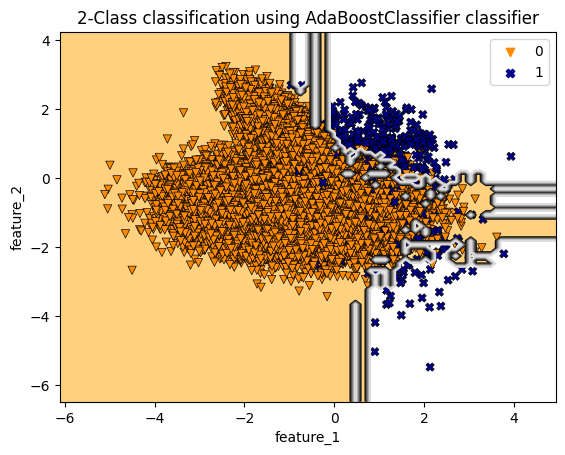

AUC-ROC Score for AdaBoostClassifier: 0.9553131451691124
Average Precision Score for AdaBoostClassifier: 0.4648038520589159
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.42      1.00      0.65      0.45     26730
          1       0.60      0.42      1.00      0.50      0.65      0.40       270

avg / total       0.99      0.99      0.43      0.99      0.65      0.44     27000

f2-score: 0.449 precision: 0.603 recall: 0.422


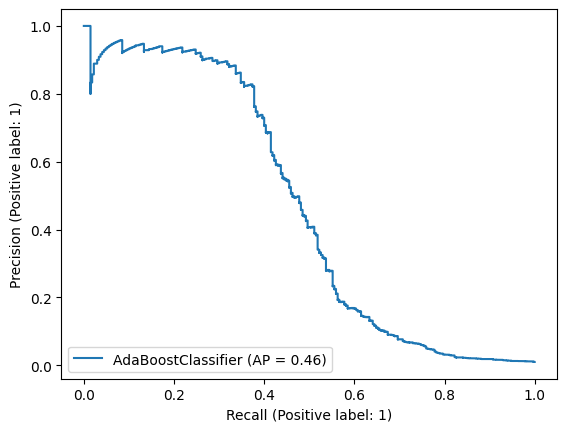

In [16]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(random_state=0, estimator=DecisionTreeClassifier(max_depth=6)).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, adaboost_clf, 'AdaBoostClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(adaboost_clf, X_test, y_test, ax = plt.gca(),name = "AdaBoostClassifier")

roc_auc_adaboost = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for AdaBoostClassifier: {roc_auc_adaboost}")

y_pred_proba = adaboost_clf.predict_proba(X_test)[:, 1]
avg_precision_adaboost = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for AdaBoostClassifier: {avg_precision_adaboost}")

y_pred = adaboost_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2, precision_val, recall_val =  compute_scores(adaboost_clf, X_test, y_test)
print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")


# RUSBoostClassifier

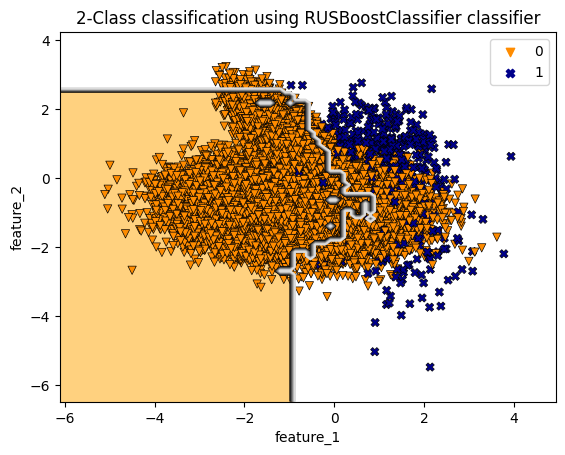

AUC-ROC Score for RUSBoostClassifier: 0.8703982901719526
Average Precision Score for RUSBoostClassifier: 0.5443291663954869
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.91      0.87      0.95      0.89      0.79     26730
          1       0.08      0.87      0.91      0.15      0.89      0.78       270

avg / total       0.99      0.90      0.87      0.94      0.89      0.79     27000

f2-score: 0.304 precision: 0.085 recall: 0.867


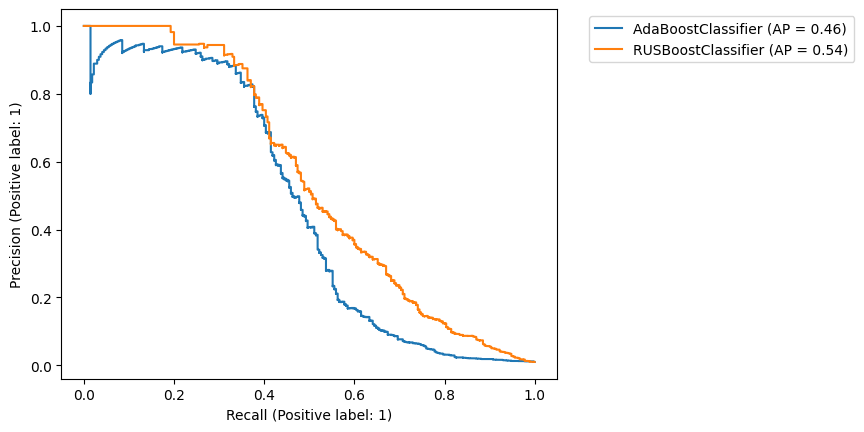

In [17]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier

rusboost_clf = RUSBoostClassifier(random_state=0, estimator=DecisionTreeClassifier(max_depth=6)).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, rusboost_clf, 'RUSBoostClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(adaboost_clf, X_test, y_test, ax = plt.gca(),name = "AdaBoostClassifier")
PrecisionRecallDisplay.from_estimator(rusboost_clf, X_test, y_test, ax = plt.gca(),name = "RUSBoostClassifier")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

roc_auc_rusboost = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for RUSBoostClassifier: {roc_auc_rusboost}")

y_pred_proba = rusboost_clf.predict_proba(X_test)[:, 1]
avg_precision_rusboost = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for RUSBoostClassifier: {avg_precision_rusboost}")

y_pred = rusboost_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_rusboost, precision_val_rusboost, recall_val_rusboost =  compute_scores(rusboost_clf, X_test, y_test)
print(f"f2-score: {f2_rusboost:.3f}", f"precision: {precision_val_rusboost:.3f}", f"recall: {recall_val_rusboost:.3f}")


# EasyEnsemble

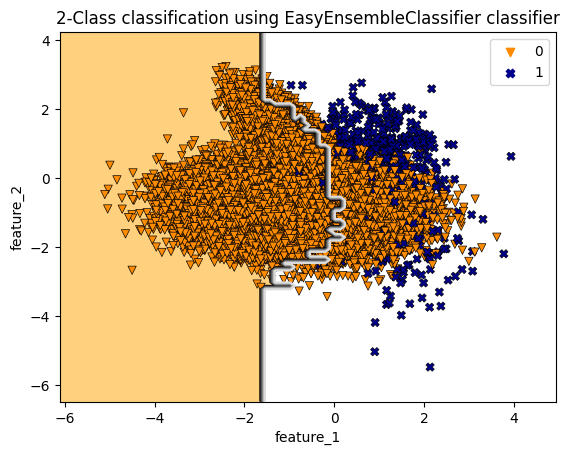

AUC-ROC Score for EasyEnsembleClassifier: 0.9406560114173281
Average Precision Score for EasyEnsembleClassifier: 0.25030862030812295
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      0.91      0.93      0.89      0.79     26730
          1       0.06      0.91      0.86      0.12      0.89      0.79       270

avg / total       0.99      0.87      0.91      0.92      0.89      0.79     27000

f2-score: 0.250 precision: 0.064 recall: 0.915


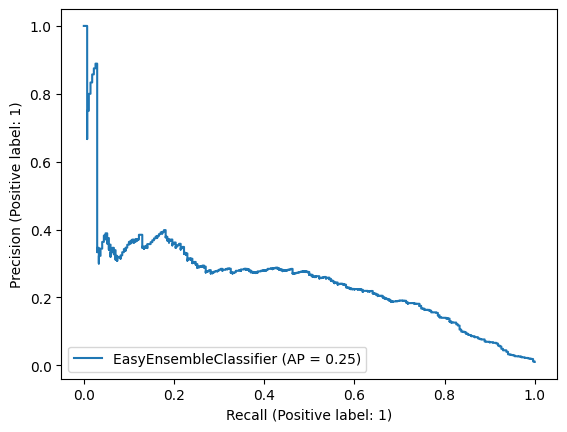

In [18]:
from imblearn.ensemble import EasyEnsembleClassifier

easyensemble_clf = EasyEnsembleClassifier(random_state=0).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, easyensemble_clf, 'EasyEnsembleClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(easyensemble_clf, X_test, y_test, ax = plt.gca(),name = "EasyEnsembleClassifier")

roc_auc_easyensemble = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for EasyEnsembleClassifier: {roc_auc_easyensemble}")

y_pred_proba = easyensemble_clf.predict_proba(X_test)[:, 1]
avg_precision_easyensemble = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for EasyEnsembleClassifier: {avg_precision_easyensemble}")

y_pred = easyensemble_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_easyensemble, precision_val_easyensemble, recall_val_easyensemble =  compute_scores(easyensemble_clf, X_test, y_test)
print(f"f2-score: {f2_easyensemble:.3f}", f"precision: {precision_val_easyensemble:.3f}", f"recall: {recall_val_easyensemble:.3f}")



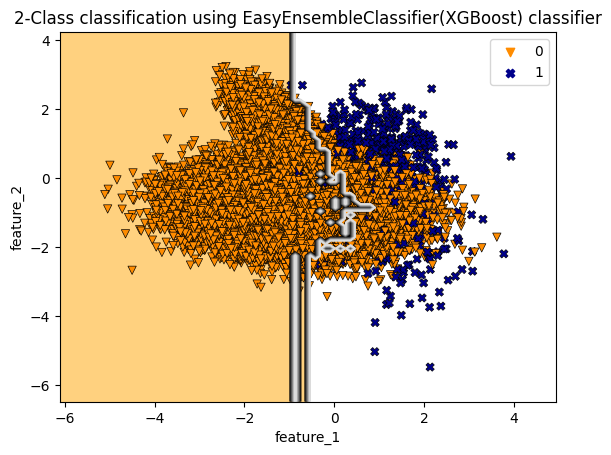

AUC-ROC Score for EasyEnsembleClassifier(XGBoost): 0.9491644150697649
Average Precision Score for EasyEnsembleClassifier(XGBoost): 0.4648038520589159
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.89      0.87      0.94      0.88      0.78     26730
          1       0.08      0.87      0.89      0.14      0.88      0.78       270

avg / total       0.99      0.89      0.87      0.93      0.88      0.78     27000

f2-score: 0.282 precision: 0.076 recall: 0.870


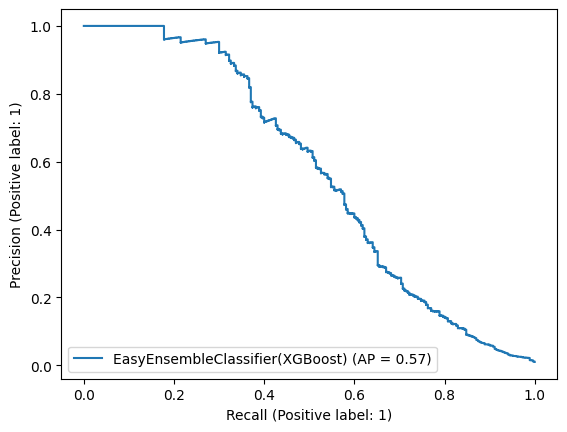

In [19]:
from imblearn.ensemble import EasyEnsembleClassifier
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay

easyensemble_clf = EasyEnsembleClassifier(n_estimators=20,
                                          random_state=42,
                                          estimator=xgb.XGBClassifier(objective="binary:logistic",random_state=42))\
                                          .fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, easyensemble_clf, 'EasyEnsembleClassifier(XGBoost)')
plt.show()

PrecisionRecallDisplay.from_estimator(easyensemble_clf, X_test, y_test, ax = plt.gca(),name = "EasyEnsembleClassifier(XGBoost)")

roc_auc_easyensemble_xgboost = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for EasyEnsembleClassifier(XGBoost): {roc_auc_easyensemble_xgboost}")

y_pred_proba = adaboost_clf.predict_proba(X_test)[:, 1]
avg_precision_easyensemble_xgboost = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for EasyEnsembleClassifier(XGBoost): {avg_precision_easyensemble_xgboost}")

y_pred = easyensemble_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_easyensemble_xgboost, precision_val_easyensemble_xgboost, recall_val_easyensemble_xgboost =  compute_scores(easyensemble_clf, X_test, y_test)
print(f"f2-score: {f2_easyensemble_xgboost:.3f}", f"precision: {precision_val_easyensemble_xgboost:.3f}", f"recall: {recall_val_easyensemble_xgboost:.3f}")


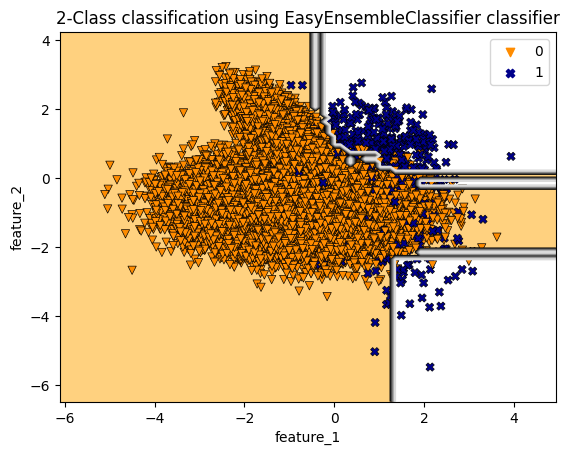

AUC-ROC Score for EasyEnsembleClassifier(XGBoost-not-majority): 0.8703982901719526
Average Precision Score for EasyEnsembleClassifier(XGBoost-not-majority): 0.4648038520589159
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.42      1.00      0.65      0.44     26730
          1       0.79      0.42      1.00      0.55      0.65      0.39       270

avg / total       0.99      0.99      0.42      0.99      0.65      0.44     27000

f2-score: 0.462 precision: 0.790 recall: 0.419


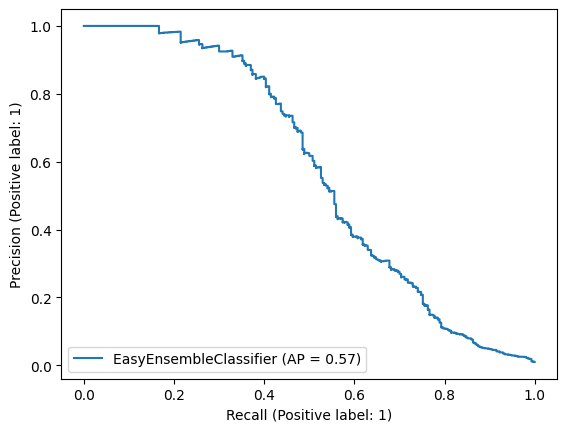

In [20]:
from imblearn.ensemble import EasyEnsembleClassifier
import xgboost as xgb

easyensemble_clf = EasyEnsembleClassifier(n_estimators=20, sampling_strategy='not majority', random_state=42, estimator=xgb.XGBClassifier(objective="binary:logistic",random_state=42)).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, easyensemble_clf, 'EasyEnsembleClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(easyensemble_clf, X_test, y_test, ax = plt.gca(),name = "EasyEnsembleClassifier")

roc_auc_easyensemble_xgboost_not_majority = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for EasyEnsembleClassifier(XGBoost-not-majority): {roc_auc_easyensemble_xgboost_not_majority}")

y_pred_proba = adaboost_clf.predict_proba(X_test)[:, 1]
avg_precision_easyensemble_xgboost_not_majority = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for EasyEnsembleClassifier(XGBoost-not-majority): {avg_precision_easyensemble_xgboost_not_majority}")

y_pred = easyensemble_clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_easyensemble_xgboost_not_majority, precision_val_easyensemble_xgboost_not_majority, recall_val_easyensemble_xgboost_not_majority =  compute_scores(easyensemble_clf, X_test, y_test)
print(f"f2-score: {f2_easyensemble_xgboost_not_majority:.3f}", f"precision: {precision_val_easyensemble_xgboost_not_majority:.3f}", f"recall: {recall_val_easyensemble_xgboost_not_majority:.3f}")



# XGBoost

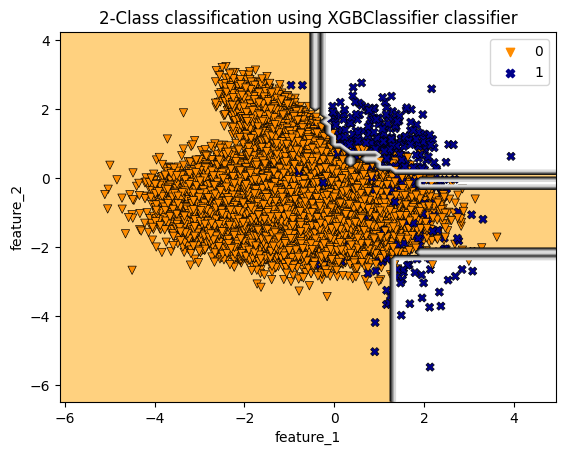

AUC-ROC Score for XGBClassifier: 0.8703982901719526
Average Precision Score for XGBClassifier: 0.5690914906275207
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.42      1.00      0.65      0.45     26730
          1       0.80      0.42      1.00      0.55      0.65      0.40       270

avg / total       0.99      0.99      0.43      0.99      0.65      0.45     27000

f2-score: 0.462 precision: 0.790 recall: 0.419


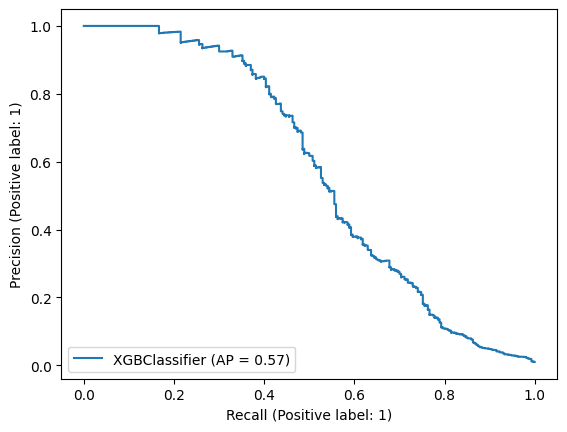

In [21]:
import xgboost as xgb
# xgb.XGBClassifier(n_estimators=50, max_depth=6)
xgboost = xgb.XGBClassifier(random_state=42).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, easyensemble_clf, 'XGBClassifier')
plt.show()

PrecisionRecallDisplay.from_estimator(easyensemble_clf, X_test, y_test, ax = plt.gca(),name = "XGBClassifier")

roc_auc_xgboost = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score for XGBClassifier: {roc_auc_xgboost}")

y_pred_proba = xgboost.predict_proba(X_test)[:, 1]
avg_precision_xgboost = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score for XGBClassifier: {avg_precision_xgboost}")

y_pred = xgboost.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

f2_xgboost, precision_val_xgboost, recall_val_xgboost =  compute_scores(easyensemble_clf, X_test, y_test)
print(f"f2-score: {f2_xgboost:.3f}", f"precision: {precision_val_xgboost:.3f}", f"recall: {recall_val_xgboost:.3f}")



# Performance comparison of Boosting methods

In [22]:
import pandas as pd

data = {
    'Technique': ['EasyEnsemble_XGBoost_Not_Majority', 'EasyEnsemble_XGBoost', 'EasyEnsemble', 'RUSBoost', 'AdaBoost', 'XGBoost', 'Decision Tree'],
    'F2 Score': [f2_easyensemble_xgboost_not_majority, f2_easyensemble_xgboost, f2_easyensemble, f2_rusboost, f2, f2_xgboost, f2_tree],
    'Precision': [precision_val_easyensemble_xgboost_not_majority, precision_val_easyensemble_xgboost, precision_val_easyensemble, precision_val_rusboost, precision_val, precision_val_xgboost, precision_val_tree],
    'Recall': [recall_val_easyensemble_xgboost_not_majority, recall_val_easyensemble_xgboost, recall_val_easyensemble, recall_val_rusboost, recall_val, recall_val_xgboost, recall_val_tree],
    'Average Precision': [avg_precision_easyensemble_xgboost_not_majority, avg_precision_easyensemble_xgboost, avg_precision_easyensemble, avg_precision_rusboost, avg_precision_adaboost, avg_precision_xgboost, avg_precision_tree],
    'AUC-ROC': [roc_auc_easyensemble_xgboost_not_majority, roc_auc_easyensemble_xgboost, roc_auc_easyensemble, roc_auc_rusboost, roc_auc_adaboost, roc_auc_xgboost, roc_auc_tree]
}

df = pd.DataFrame(data)

print(df.round(3))
df.round(3).style.highlight_max(color = 'yellow', axis = 0)


                           Technique  F2 Score  Precision  Recall  \
0  EasyEnsemble_XGBoost_Not_Majority     0.462      0.790   0.419   
1               EasyEnsemble_XGBoost     0.282      0.076   0.870   
2                       EasyEnsemble     0.250      0.064   0.915   
3                           RUSBoost     0.304      0.085   0.867   
4                           AdaBoost     0.449      0.603   0.422   
5                            XGBoost     0.462      0.790   0.419   
6                      Decision Tree     0.431      0.825   0.385   

   Average Precision  AUC-ROC  
0              0.465    0.870  
1              0.465    0.949  
2              0.250    0.941  
3              0.544    0.870  
4              0.465    0.955  
5              0.569    0.870  
6              0.479    0.930  


,Technique,F2 Score,Precision,Recall,Average Precision,AUC-ROC
0,EasyEnsemble_XGBoost_Not_Majority,0.462000,0.790000,0.419000,0.465000,0.870000
1,EasyEnsemble_XGBoost,0.282000,0.076000,0.870000,0.465000,0.949000
2,EasyEnsemble,0.250000,0.064000,0.915000,0.250000,0.941000
3,RUSBoost,0.304000,0.085000,0.867000,0.544000,0.870000
4,AdaBoost,0.449000,0.603000,0.422000,0.465000,0.955000
5,XGBoost,0.462000,0.790000,0.419000,0.569000,0.870000
6,Decision Tree,0.431000,0.825000,0.385000,0.479000,0.930000


# Final comparison

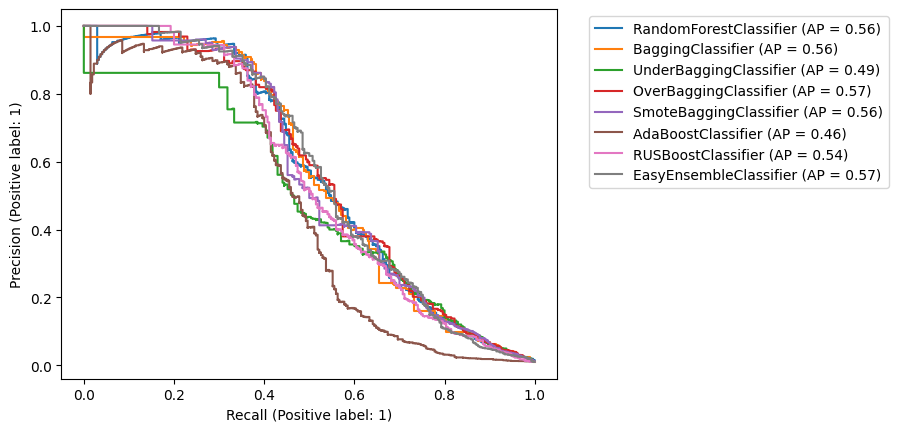

In [23]:
PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "RandomForestClassifier")
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax = plt.gca(),name = "BaggingClassifier")
PrecisionRecallDisplay.from_estimator(underbagging_clf, X_test, y_test, ax = plt.gca(),name = "UnderBaggingClassifier")
PrecisionRecallDisplay.from_estimator(overbagging_clf, X_test, y_test, ax = plt.gca(),name = "OverBaggingClassifier")
PrecisionRecallDisplay.from_estimator(smotebagging_clf, X_test, y_test, ax = plt.gca(),name = "SmoteBaggingClassifier")
PrecisionRecallDisplay.from_estimator(adaboost_clf, X_test, y_test, ax = plt.gca(),name = "AdaBoostClassifier")
PrecisionRecallDisplay.from_estimator(rusboost_clf, X_test, y_test, ax = plt.gca(),name = "RUSBoostClassifier")
PrecisionRecallDisplay.from_estimator(easyensemble_clf, X_test, y_test, ax = plt.gca(),name = "EasyEnsembleClassifier")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

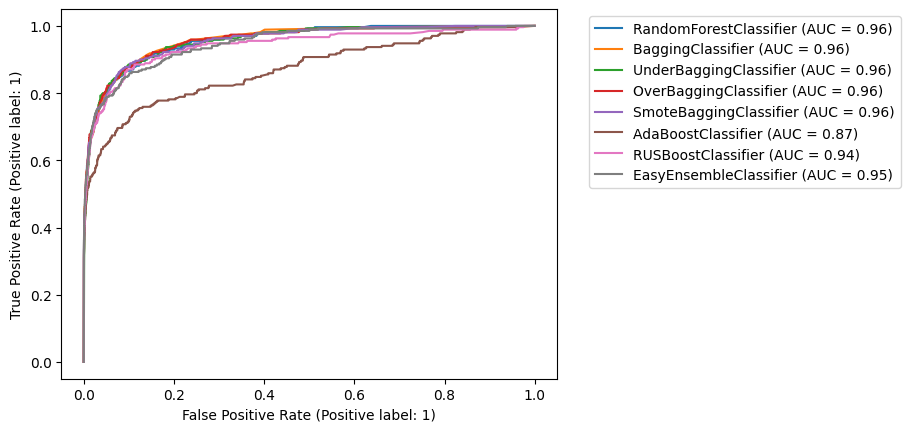

In [24]:
RocCurveDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "RandomForestClassifier")
RocCurveDisplay.from_estimator(clf, X_test, y_test, ax = plt.gca(),name = "BaggingClassifier")
RocCurveDisplay.from_estimator(underbagging_clf, X_test, y_test, ax = plt.gca(),name = "UnderBaggingClassifier")
RocCurveDisplay.from_estimator(overbagging_clf, X_test, y_test, ax = plt.gca(),name = "OverBaggingClassifier")
RocCurveDisplay.from_estimator(smotebagging_clf, X_test, y_test, ax = plt.gca(),name = "SmoteBaggingClassifier")
RocCurveDisplay.from_estimator(adaboost_clf, X_test, y_test, ax = plt.gca(),name = "AdaBoostClassifier")
RocCurveDisplay.from_estimator(rusboost_clf, X_test, y_test, ax = plt.gca(),name = "RUSBoostClassifier")
RocCurveDisplay.from_estimator(easyensemble_clf, X_test, y_test, ax = plt.gca(),name = "EasyEnsembleClassifier")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

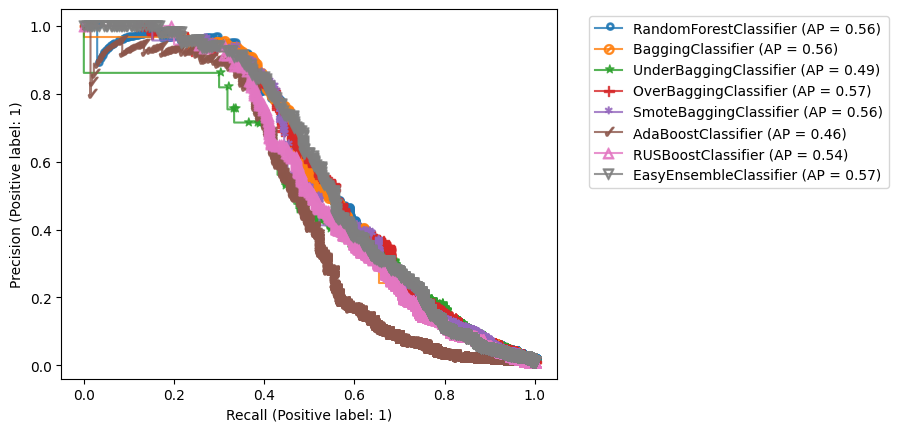

In [25]:
def kwargs(num):
  return {'alpha': 0.8, 'marker': getRandomMarker(num), 'markersize': 8}

markers = ['\circ', '\oslash',
           '\star', '+', '*',
            '\\checkmark', '\\vartriangle', '\\triangledown', '\\blacktriangle']

def getRandomMarker(i):
  return "$"+markers[i]+"$"

PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "RandomForestClassifier", **kwargs(0))
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax = plt.gca(),name = "BaggingClassifier", **kwargs(1))
PrecisionRecallDisplay.from_estimator(underbagging_clf, X_test, y_test, ax = plt.gca(),name = "UnderBaggingClassifier", **kwargs(2))
PrecisionRecallDisplay.from_estimator(overbagging_clf, X_test, y_test, ax = plt.gca(),name = "OverBaggingClassifier", **kwargs(3))
PrecisionRecallDisplay.from_estimator(smotebagging_clf, X_test, y_test, ax = plt.gca(),name = "SmoteBaggingClassifier", **kwargs(4))
PrecisionRecallDisplay.from_estimator(adaboost_clf, X_test, y_test, ax = plt.gca(),name = "AdaBoostClassifier", **kwargs(5))
PrecisionRecallDisplay.from_estimator(rusboost_clf, X_test, y_test, ax = plt.gca(),name = "RUSBoostClassifier", **kwargs(6))
PrecisionRecallDisplay.from_estimator(easyensemble_clf, X_test, y_test, ax = plt.gca(),name = "EasyEnsembleClassifier", **kwargs(7))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
